In [1]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd 
import matplotlib.pyplot as plt

[-1.97239402e-08 -2.65602499e-05  7.08213401e+02  8.96233301e-03
  2.05540003e-02  1.59169687e-03 -1.83285217e-01  3.64225252e+00
 -3.70410955e+01]
[-1.71816565e-02 -4.63175982e-03  7.36194825e+02  8.96767944e-01
  2.21677528e-02  7.42532035e-06 -1.90423357e-03  7.62118534e-02
  1.96353893e+02]
[-2.00494718e-02  1.56485445e-02  6.60512025e+02 -2.76081768e-01
  2.35693025e-02 -2.46011062e-06  1.12753835e-03 -1.49208025e-01
  2.25174202e+01]
[ 2.40775553e-02 -1.63156112e-05  6.72721108e+02  3.27007168e-02
  2.09235929e-02  1.42212856e-03 -7.02354096e-01  8.74975539e+01
 -3.12785141e-08]


/opt/anaconda3/envs/py3/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/py3/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/py3/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/py3/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

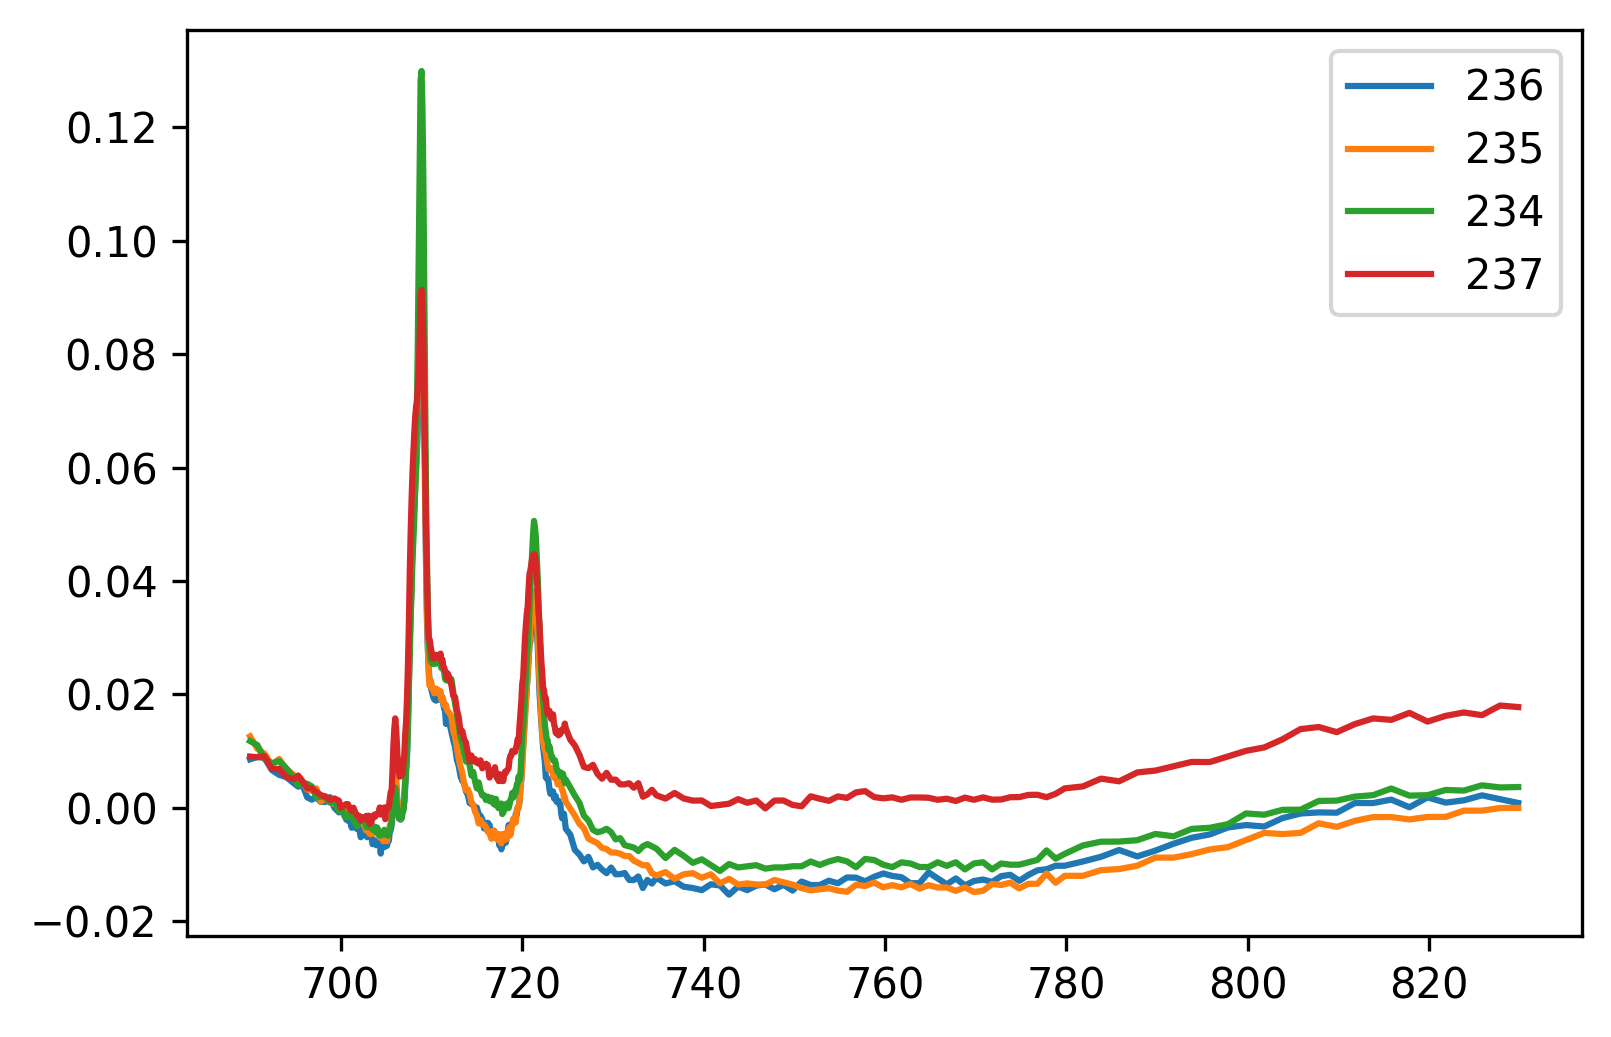

In [2]:
def arcTan(energy,offset):
    """
    Calculate a custom arctangent-based background function.
    
    Parameters
    ----------
    energy : array-like
        Array of energy values.
    
    offset : float
        Offset value for the arctangent calculation.
    
    Returns
    -------
    array-like
        Computed arctangent background values.
    """
    return (np.arctan(0.294970428662657*(energy-offset))+np.pi/2)*2/(3*np.pi)+(np.arctan(0.294970428662657*(energy-(offset+12.3)))+np.pi/2)*1/(3*np.pi)
#(ATAN(0.294970428662657*(A2-$N$5))+PI()/2)*2/(3*PI())+(ATAN(0.294970428662657*(A2-($N$5+12.3)))+PI()/2)*1/(3*PI())
def retLin(x,m,c,b):
    return m*(x-c)+b
def polyback(energy,*parms):
    """
    Combine a polynomial and an arctangent function for background correction.

    Parameters
    ----------
    energy : array-like
        Array of energy values.
    
    *parms : variable length argument list
        Parameters for the polynomial and arctangent functions.
        
    Returns
    -------
    array-like
        Combination of polynomial and arctangent background values.
    """
    #scale=np.abs(parms[0])
    scale_tan=np.abs(parms[0])
    scale_poly=parms[1]
    poly_x_offset=parms[2]
    poly_y_offset=parms[3]
    poly=parms[5:]
    arctan_offset=710
    return (scale_poly*np.poly1d(poly)(energy-poly_x_offset)+poly_y_offset)+scale_tan*arcTan(energy,arctan_offset)
def Ledge_it_up_new(outDF,weight_range=[700,735,740,760,800,999],deg=2):
    """
    Perform polynomial fitting with weighted ranges for data normalization.

    Parameters
    ----------
    outDF : pandas.DataFrame
        DataFrame containing the spectral data. Must have an 'Sum' column.

    weight_range : list, optional
        List of energy ranges to apply 0 weights, by default [705, 735, 740, 760, 800, 999].
        Basically each pair of numbers defines the range to ignore for fitting background. E.g. 
        E.g. L3,L2,delayed-onset region, extreme post-edge (if buggy mono)
    deg : int, optional
        Degree of the polynomial used for the fitting, by default 3.
    
    Returns
    -------
    pandas.DataFrame
        Modified DataFrame with additional columns for background corrections and normalization.
    """
    x=outDF.index.values
    outDF['Sum_shifted']=outDF['Sum'].values-np.min(outDF['Sum'].values)
    y=outDF['Sum_shifted'].values
    sig=np.ones(len(x))
    weight_idx=[]
    current_idx=0
    arctan_energy=710
    for idx,i in enumerate(weight_range[::2]):
        idx_val=(np.argmin(np.abs(x-i)))
        nex_val=(np.argmin(np.abs(x-weight_range[idx+1*(idx+1)])))
        sig[idx_val:nex_val+1]=0.000001
        weight_idx.append(idx_val)
        current_idx=idx_val
    norm_idx=np.argmin(np.abs(x-730))

    #parms=np.polynomial.polynomial.Polynomial.fit(x,y,deg,w=sig).convert().coef#np.polyfit(x,y,deg,w=1.0/sig)
    e_guess=np.mean(x)
    parms=np.polynomial.polynomial.Polynomial.fit(x-e_guess,y,deg,w=1/sig).convert().coef#np.polyfit(x,y,deg,w=1.0/sig)
    #guess=[y[norm_idx],-2.70757748e-07, -7.24420661e-07,  2.62574543e-02, -6.12176539e+01 ,4.84123131e+04, -1.27260427e+07]
    
    guess=np.hstack([y[norm_idx],y[norm_idx],e_guess,e_guess,parms])
    mins=np.tile(-1*np.inf,len(guess))
    maxs=np.tile(np.inf,len(guess))
    #mins[0]=y[norm_idx]-y[norm_idx]*0.5
    #maxs[0]=y[norm_idx]+y[norm_idx]*0.1
   
    popt,pcov=curve_fit(polyback,x,y,p0=guess,sigma=1/sig,maxfev=99999999,bounds=(mins,maxs),ftol=1E-10,xtol=1E-10)
    outDF['poly_back']=polyback(x,*popt)
    outDF['arc_back']=np.abs(popt[0])*arcTan(x,arctan_energy)
    outDF['subtracted']=y-polyback(x,*popt)
    outDF['subtracted_added_arc']=outDF['subtracted']+np.abs(popt[0])*arcTan(x,arctan_energy)
    outDF['normalized']=outDF['subtracted_added_arc'].values/outDF['subtracted_added_arc'].values[norm_idx]
    outDF['subtracted_normalized']=outDF['normalized']-arcTan(x,arctan_energy)
    print(popt)
    return outDF
names='MONO  Epoch  Seconds  QUAD_ENC  GRATING_ENC  ENERGY_ENC  CMACT  CH  FY  REF  I1  testfy  CTEMP  SAMPLEZ_ENC  I0  SC  CK  FeLab  FeLln  NK  OK'
names=names.split()
scans_compound1=[]
compd_1=[236,235,234,237]
for idx,file in enumerate(compd_1):
    if idx==0:
        scans_compound1.append(pd.read_csv(r'/Users/lbgee/Library/CloudStorage/OneDrive-SLACNationalAcceleratorLaboratory/SLAC/LCLS Bioinorganic/Projects/FeNO/Experimental_Data/L-Edge_XAS/20220713_thomas/data_files/htxs_xas_20220713_updated_%03d.dat' % (file),names=names,comment='#',delimiter='\s+',index_col='MONO'))
    if idx>0:
        scans_compound1.append(pd.read_csv(r'/Users/lbgee/Library/CloudStorage/OneDrive-SLACNationalAcceleratorLaboratory/SLAC/LCLS Bioinorganic/Projects/FeNO/Experimental_Data/L-Edge_XAS/20220713_thomas/data_files/htxs_xas_20220713_updated_%03d.dat' % (file),names=names,comment='#',delimiter='\s+',index_col='MONO'))
plt.figure()
xaxis_1=scans_compound1[-1].index.values
yaxis_1=scans_compound1[-1]['SC']/scans_compound1[-1]['I0'].values
from scipy.interpolate import interp1d
plt.figure(dpi=300)
Complex_1_out=[]
for idx,i in enumerate(scans_compound1[0:]):

        interp=interp1d(i.index.values,i['SC']/i['I0']-(i['SC'].values[idx]/i['I0'].values[idx]),fill_value=0,bounds_error=False)
        idx=np.argmin(np.abs(i.index.values-700))
        plt.plot(i.index.values,i['SC']/i['I0']-(i['SC'].values[idx]/i['I0'].values[idx]))
        yaxis1_temp=interp(xaxis_1)
        Complex_1_sum=pd.DataFrame(np.transpose([xaxis_1,yaxis1_temp]),columns=['Energy','Sum'])
        Complex_1_sum=Complex_1_sum.set_index('Energy')
        Complex_1_sum=Complex_1_sum[(Complex_1_sum.index>690) & (Complex_1_sum.index<800)]
        Complex_1_out.append(Ledge_it_up_new(Complex_1_sum,deg=4))
plt.legend(compd_1)    


<AxesSubplot:xlabel='Energy'>

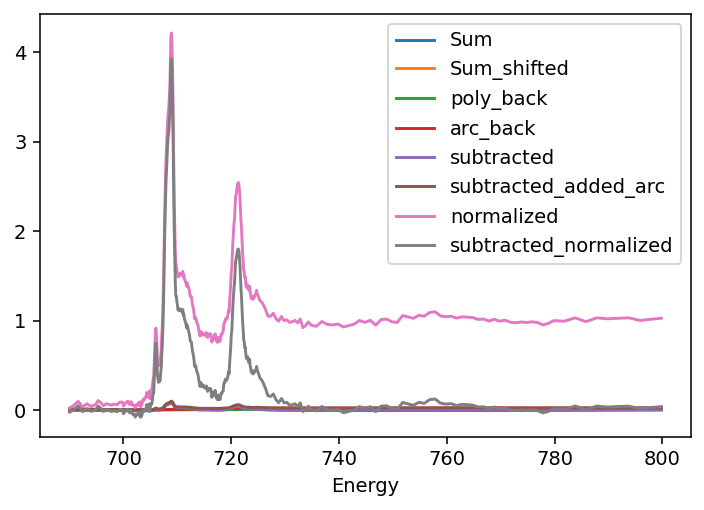

In [3]:
fig=plt.figure(dpi=140)
Complex_1_sum.plot(ax=plt.gca())

<AxesSubplot:xlabel='Energy'>

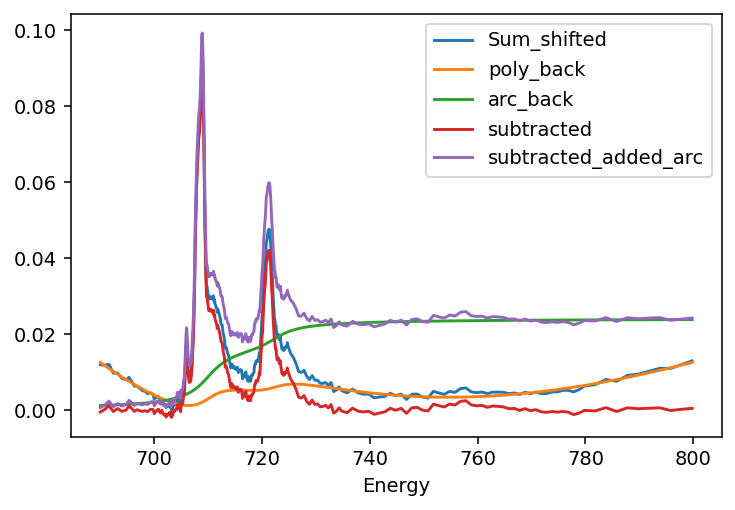

In [4]:
fig=plt.figure(dpi=140)
Complex_1_sum.plot(y=['Sum_shifted','poly_back','arc_back','subtracted','subtracted_added_arc'],ax=plt.gca())